In [83]:
from sklearn.svm import OneClassSVM
from sklearn.ensemble import IsolationForest
from sklearn.metrics import *

from sklearn.preprocessing import StandardScaler

import seaborn as sns
import matplotlib.pyplot as plt
import time

In [84]:
from helpers.data_preprocessing import *

In [85]:
data = load_and_preprocess_data("Dataset/cic-ids_dataset.csv")
data

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,80,9392887,4,0,24,0,6,6,6.000000,0.000000,...,20,1.982000e+03,0.0000,1982,1982,9390905.0,0.0000,9390905,9390905,DDoS
1,64007,5438011,1,5,6,30,6,6,6.000000,0.000000,...,20,2.715100e+04,0.0000,27151,27151,5410860.0,0.0000,5410860,5410860,BENIGN
2,80,115615609,20,15,1728,3463,578,0,86.400000,211.017934,...,32,1.609163e+05,134508.6864,566475,120118,10100000.0,46752.4843,10100000,9988018,BENIGN
3,80,9827,3,5,26,11601,20,0,8.666667,10.263203,...,20,0.000000e+00,0.0000,0,0,0.0,0.0000,0,0,DDoS
4,53315,87583370,7,9,11607,62,4380,0,1658.142857,1762.272815,...,20,4.219842e+06,0.0000,4219842,4219842,82600000.0,0.0000,82600000,82600000,BENIGN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19410,444,119299621,2805,2028,13712,7878627,5792,0,4.888414,110.120790,...,32,0.000000e+00,0.0000,0,0,0.0,0.0000,0,0,Heartbleed
19411,444,119297996,2782,2089,9368,7882432,1448,0,3.367362,30.505030,...,32,0.000000e+00,0.0000,0,0,0.0,0.0000,0,0,Heartbleed
19412,444,119257653,2802,2067,20858,7812389,5792,0,7.443969,126.045811,...,32,0.000000e+00,0.0000,0,0,0.0,0.0000,0,0,Heartbleed
19413,444,119260295,2791,2114,13712,7878088,5792,0,4.912934,110.396187,...,32,0.000000e+00,0.0000,0,0,0.0,0.0000,0,0,Heartbleed


In [86]:
# Encode labels: BENIGN = 0, Attack = 1
data['Label'] = data['Label'].apply(lambda x: 0 if x == 'BENIGN' else 1)

In [87]:
# Separate features and labels
X = data.drop('Label', axis=1)
y = data['Label']

In [88]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

In [89]:
# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Isolation Forest

In [90]:
# Initialize Isolation Forest
iso_forest = IsolationForest(contamination=0.1, random_state=42)  # Contamination = expected % of anomalies

In [91]:
# Train the model
start_time = time.time()

iso_forest.fit(X_train)

training_time_iso_forest = time.time() - start_time

In [92]:
# Predict anomalies (-1 for anomalies, 1 for normal)
y_pred_iso_forest = iso_forest.predict(X_test)

In [93]:
# Convert predictions to binary (0: normal, 1: anomaly)
y_pred_iso_forest = np.where(y_pred_iso_forest == -1, 1, 0)

In [94]:
precision_iso_forest = precision_score(y_test, y_pred_iso_forest)
recall_iso_forest = recall_score(y_test, y_pred_iso_forest)
f1_iso_forest = f1_score(y_test, y_pred_iso_forest)

In [95]:
# Evaluate the model
print("Isolation Forest Results:")
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_iso_forest))
print("\nClassification Report:\n", classification_report(y_test, y_pred_iso_forest))
print("Accuracy:", accuracy_score(y_test, y_pred_iso_forest))

Isolation Forest Results:
Confusion Matrix:
 [[2642  210]
 [2559  407]]

Classification Report:
               precision    recall  f1-score   support

           0       0.51      0.93      0.66      2852
           1       0.66      0.14      0.23      2966

    accuracy                           0.52      5818
   macro avg       0.58      0.53      0.44      5818
weighted avg       0.59      0.52      0.44      5818

Accuracy: 0.5240632519766243


In [96]:
# Print results
print("Isolation Forest:")
print(f"Precision: {precision_iso_forest:.2f}")
print(f"Recall: {recall_iso_forest:.2f}")
print(f"F1-Score: {f1_iso_forest:.2f}")
print(f"Training Time (s): {training_time_iso_forest:.2f}")

Isolation Forest:
Precision: 0.66
Recall: 0.14
F1-Score: 0.23
Training Time (s): 0.16


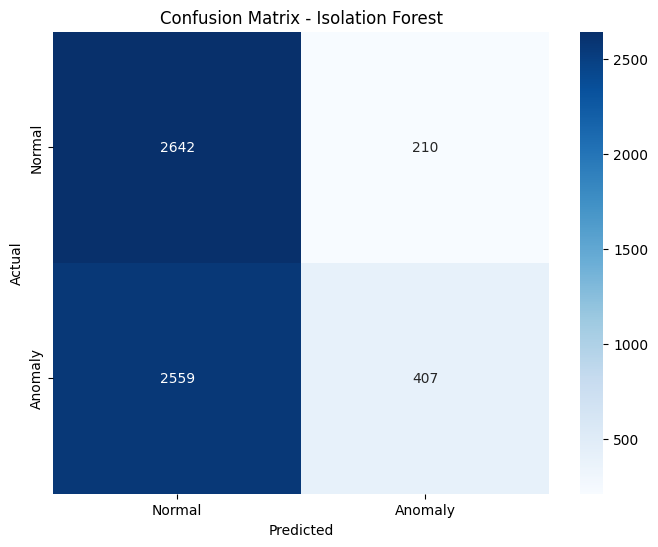

In [109]:
# Plot confusion matrix for Isolation Forest model
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred_iso_forest), annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Normal', 'Anomaly'], yticklabels=['Normal', 'Anomaly'])
plt.title('Confusion Matrix - Isolation Forest')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

One-Class SVM

In [98]:
# Initialize One-Class SVM
one_class_svm = OneClassSVM(nu=0.1, kernel='rbf', gamma='scale')  # nu = expected % of anomalies

In [99]:
# Train the model (only on normal data)
normal_data = X_train[y_train == 0]  # Use only BENIGN data for training

start_time = time.time()
one_class_svm.fit(normal_data)

training_time_one_class_svm = time.time() - start_time

In [100]:
# Predict anomalies (-1 for anomalies, 1 for normal)
y_pred_one_class_svm = one_class_svm.predict(X_test)


In [101]:
# Convert predictions to binary (0: normal, 1: anomaly)
y_pred_one_class_svm = np.where(y_pred_one_class_svm == -1, 1, 0)

In [102]:
# Evaluate the model
print("One-Class SVM Results:")
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_one_class_svm))
print("\nClassification Report:\n", classification_report(y_test, y_pred_one_class_svm))
print("Accuracy:", accuracy_score(y_test, y_pred_one_class_svm))

One-Class SVM Results:
Confusion Matrix:
 [[2554  298]
 [1680 1286]]

Classification Report:
               precision    recall  f1-score   support

           0       0.60      0.90      0.72      2852
           1       0.81      0.43      0.57      2966

    accuracy                           0.66      5818
   macro avg       0.71      0.66      0.64      5818
weighted avg       0.71      0.66      0.64      5818

Accuracy: 0.6600206256445514


In [103]:
precision_ocsvm = precision_score(y_test, y_pred_one_class_svm)
recall_ocsvm = recall_score(y_test, y_pred_one_class_svm)
f1_ocsvm = f1_score(y_test, y_pred_one_class_svm)

In [104]:
print("\nOne Class SVM:")
print(f"Precision: {precision_ocsvm:.2f}")
print(f"Recall: {recall_ocsvm:.2f}")
print(f"F1-Score: {f1_ocsvm:.2f}")
print(f"Training Time (s): {training_time_one_class_svm:.2f}")


One Class SVM:
Precision: 0.81
Recall: 0.43
F1-Score: 0.57
Training Time (s): 0.30


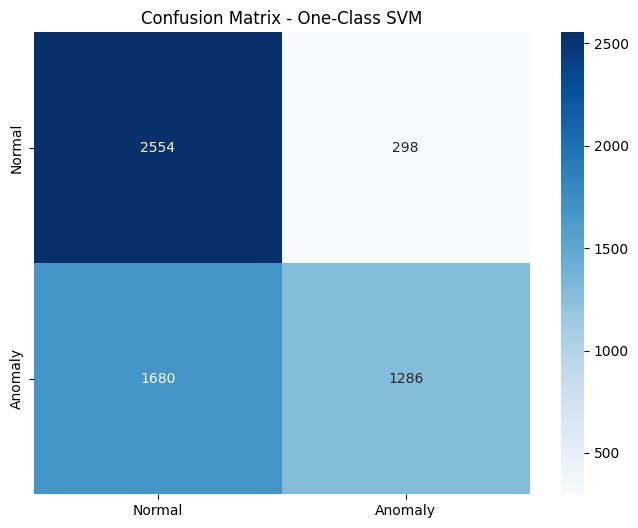

In [105]:
# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred_one_class_svm), annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Normal', 'Anomaly'], yticklabels=['Normal', 'Anomaly'])
plt.title('Confusion Matrix - One-Class SVM')
plt.show()

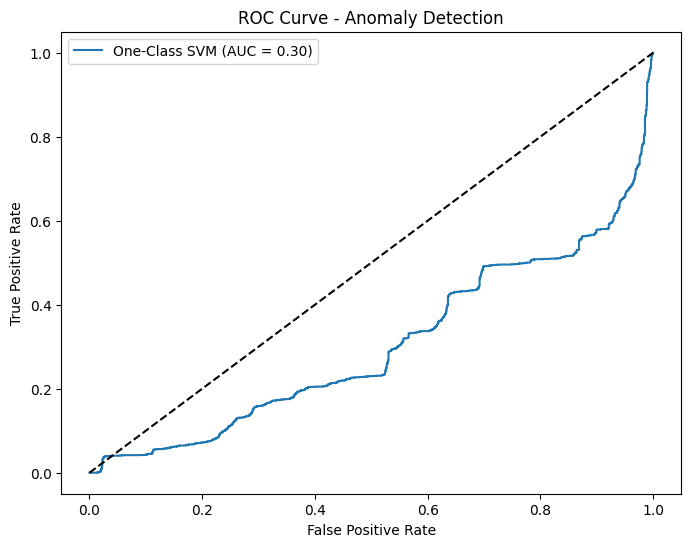

In [106]:
# Example for One-Class SVM
y_scores = one_class_svm.decision_function(X_test)  # Anomaly scores
fpr, tpr, thresholds = roc_curve(y_test, y_scores)
auc = roc_auc_score(y_test, y_scores)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'One-Class SVM (AUC = {auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Random guess line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Anomaly Detection')
plt.legend()
plt.show()

In [107]:
from sklearn.manifold import TSNE

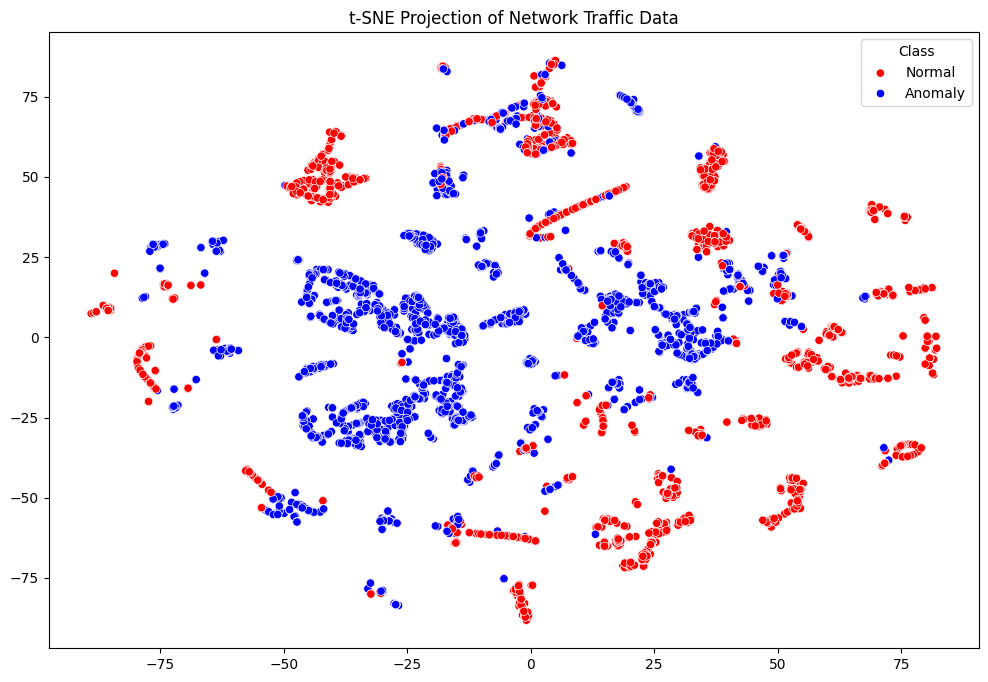

In [108]:
# Perform t-SNE
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_test)

# Plot t-SNE projection
plt.figure(figsize=(12, 8))
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=y_test, palette={0: 'blue', 1: 'red'}, legend='full')
plt.title('t-SNE Projection of Network Traffic Data')
plt.legend(title='Class', labels=['Normal', 'Anomaly'])
plt.show()